In [3]:
import site, pathlib, subprocess, sys
sys.path.insert(0,"/home/mt622/GitHubRepos/FractionalBrownianMotion")
repo_root = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], text=True
).strip()
pth_dir = pathlib.Path(site.getsitepackages()[0])
(pth_dir / "namerepo_root.pth").write_text(repo_root + "\n")
print("Wrote", pth_dir / "namerepo_root.pth")

Wrote /Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages/namerepo_root.pth


In [4]:
from utils.drift_evaluation_functions import multivar_score_based_MLP_drift_OOS
from configs import project_config
import numpy as np
import torch
import os
from tqdm import tqdm
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion
from src.generative_modelling.models.TimeDependentScoreNetworks.ClassConditionalMarkovianTSPostMeanScoreMatching import \
    ConditionalMarkovianTSPostMeanScoreMatching

In [5]:
# Data parameters
from configs.RecursiveVPSDE.Markovian_20DLorenz.recursive_Markovian_PostMeanScore_20DLorenz_Stable_T256_H05_tl_110data_StbleTgt import get_config
config = get_config()

In [6]:
assert (config.hurst == 0.5)
assert (config.early_stop_idx == 0)
assert (config.tdata_mult == 110)
assert config.forcing_const == 1.25
assert (config.feat_thresh != 1./1.)
print(config.scoreNet_trained_path, config.dataSize)
rng = np.random.default_rng()
scoreModel = ConditionalMarkovianTSPostMeanScoreMatching(
    *config.model_parameters)
diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/trained_models/trained_rec_PM_ST_0010FTh_MLP_2LFac_NSTgtNFMReg_8DLnz_125e+00FConst_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_MLP_H4_CUp20_tl110 40000


In [7]:
remote_file_path = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 10240

In [17]:
def get_drift_files(config, root_dir, num_paths):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/20DLnzGPU/"
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file) and "LongerDrift" in file:
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return np.load(true_files[0]), np.load(local_files[0]), bws

In [18]:
all_true_states, all_global_states, _ = get_drift_files(config=config, root_dir=remote_file_path, num_paths=num_paths)

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_53474/3316524454.py:5: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_53474/3316524454.py:6: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


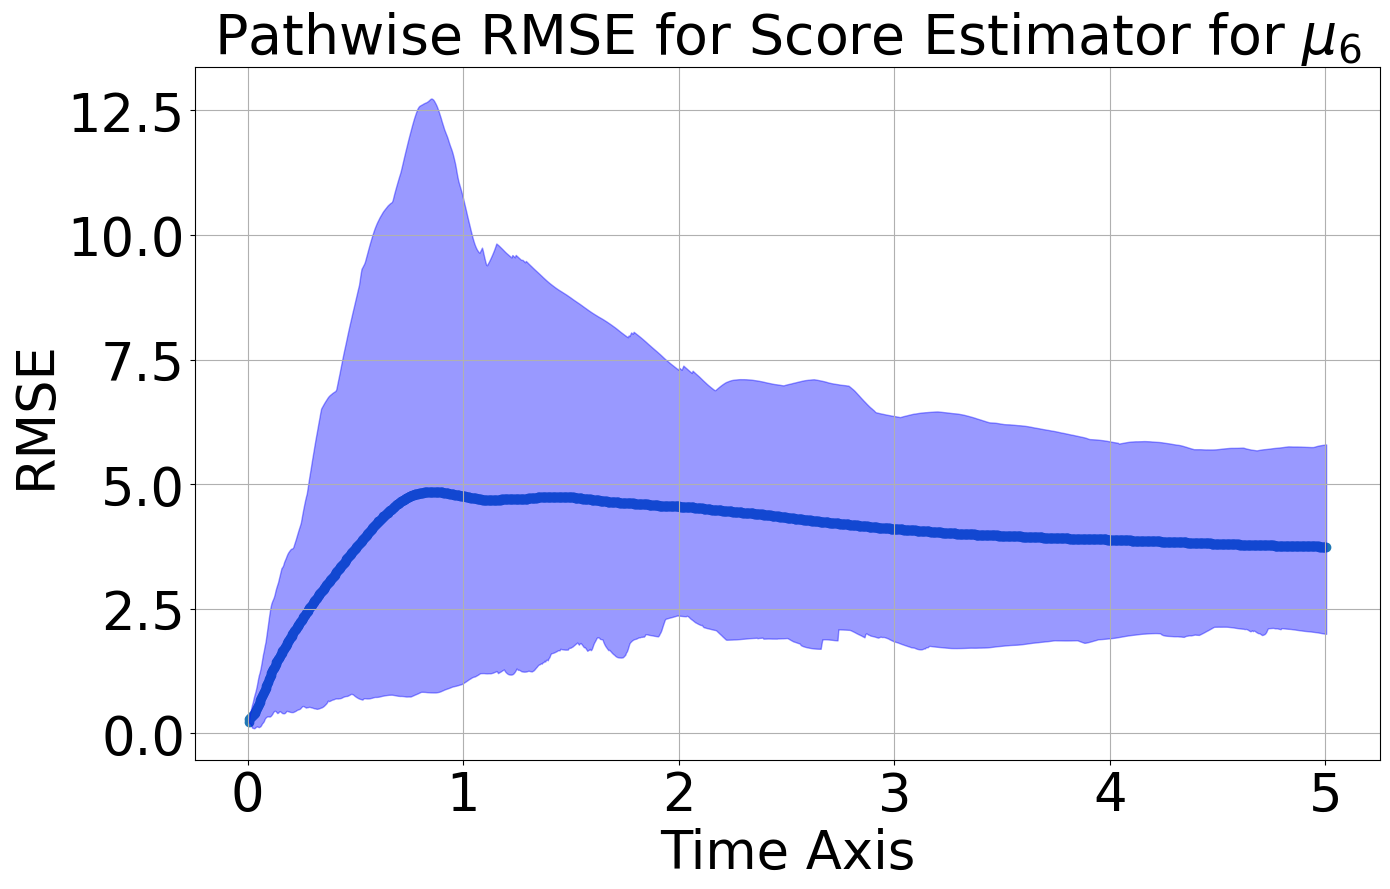

Final time cumulative MSE local-time error 3.7462755050841174 with final IQR (1.9957216932866015, 5.796800329339545) for 1.25FConst



In [19]:
import matplotlib.pyplot as plt
time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
all_global_errors = np.sum(np.power(all_true_states- all_global_states,2), axis=-1)
all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
total_local_errors = np.sqrt(np.mean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
total_local_errors[total_local_errors==np.inf] = 0.
all_paths_err[all_paths_err==np.inf] = 0.
total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)<
curr_rmse = total_local_errors[-1]
fig, ax = plt.subplots(figsize=(14,9))
plt.grid(True)
ax.scatter(time_steps, total_local_errors)
plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
ax.set_title(rf"Nadaraya for $\mu_6$ with $D=20, F=0.75$",fontsize=40)
ax.set_ylabel("Time-normalised RMSE", fontsize=38)
ax.set_xlabel("Time Axis", fontsize=38)
ax.tick_params(labelsize=38)
plt.tight_layout()
plt.show()
plt.close()
print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} for {config.forcing_const}FConst\n")